In [255]:
# import relevant depedencies
using LinearAlgebra
using TensorKit
using MPSKit
using Plots
using LaTeXStrings


Analyse if a MPS entropy grows quickly when increasing just the virtual dimension:
    MPS = small subset of Hilbert space
    
    " Het probleem is dat het random initializeren van een MPS helemaal geen random state in de volledige Hilbert space is, en de relevante measure die het moeilijker maakt om een state te benaderen is eigenlijk de hoeveelheid entanglement entropie. Vermoedelijk ga je zien dat die tamelijk laag is, en naarmate je random states met grotere bonddimensie niet noodzakelijkerwijze toeneemt "


De nieuwe approach in analyseren van de computationele cost komt nu overeen met na te denken over hoe de entanglement in een random state initieel zo kan zijn dat deze overeenkomt met een fysische relevante state. De benadering van de MPS te initialiseren met maximal entanglement tussen subsystems A en B door een matrix in het midden te steken met singuliere waardne (lees entanglement) die allemaal 1/D zijn. 

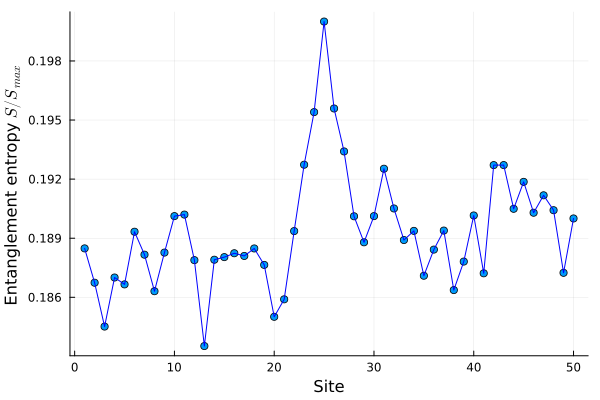

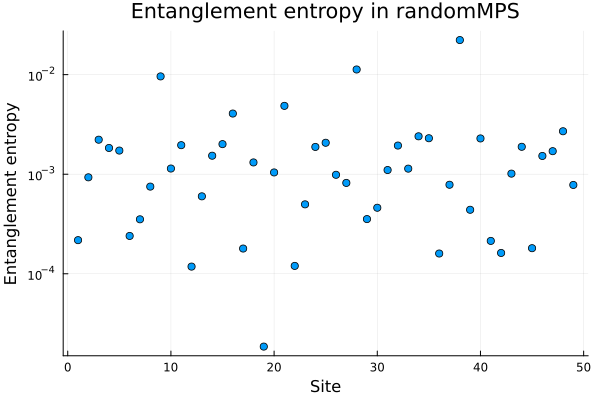

In [256]:
function generate_entangled_mps(L, D, physical_size)

    """
    Function which utilizes the mixed canonical form of a MPS to generate
    a highly entangled MPS.
    Returns this state as a FiniteMPS object and on top of that 
    returns the S_max
    """

    # For mps of length L (asumme L is even) we want L/2 left canonical tensors
    # spanning the basis for subspace A and L/2 right canonical tesnors spanning
    # the basis for subspace B, between these two tensors should be a diagonal
    # bond matrix with values all equal to 1/D.

    #eg. MPS of length 8 = QL QL QL QL QL --- [bond matrix]---- QR QR QR QR
    # to mps -> contract [bond matrix]^(1/2) to both sides of the mps, one into
    # the left and one into the right

    # An array of TensorMaps can be converted to a FiniteMPS! 
    tensor_list = []
    entanglement_spectrum = TensorMap(sqrt(diagm([1/D for i in 1:D])), ℝ^D, ℝ^D)

    for i in 1:Int(L)
        if i < Int(floor(L/2))

        #append a random left canonical tensor
        dims = (D*physical_size, D)
        QL = TensorMap(randisometry(dims), ℝ^(D) ⊗ ℝ^(physical_size), ℝ^D)
        push!(tensor_list, QL)

        end
        

        if i == Int(floor(L/2))
            dims = (D*physical_size, D)

            QL = TensorMap(randisometry((D*physical_size, D)), ℝ^(D) ⊗ ℝ^(physical_size), ℝ^D)
            QR = TensorMap(convert(Array{Float64, 2}, transpose(randisometry(dims))), ℝ^D ⊗ ℝ^physical_size, ℝ^D)
            #entanglement_spectrum = TensorMap(sqrt(diagm([1/D for i in 1:D])), ℝ^D, ℝ^D)
            QL_mid = QL * entanglement_spectrum
            QR_mid =  QR * entanglement_spectrum

            push!(tensor_list, QL_mid)
            push!(tensor_list, QR_mid)

        end
        
        if i > Int(floor(L/2))+1
            dims = (D*physical_size, D)

            QR = TensorMap(convert(Array{Float64, 2}, transpose(randisometry(dims))), ℝ^D ⊗ ℝ^physical_size, ℝ^D)
            push!(tensor_list, QR)
        end
 
    end
    S_max_mps = log(D)
    return FiniteMPS([tmap for tmap in tensor_list]), S_max_mps
end
 
entangledMPS, S_max = generate_entangled_mps(50, 10, 2)

# Once the MPS is generated, lets evaluate its entanglement properties along the chain
entanglement_along_chain = []
site_nr = collect(1:length(entangledMPS))
for i in site_nr
    S_exact =  sum(real, entropy(entangledMPS, i))
    push!(entanglement_along_chain, S_exact)
end




p = plot(site_nr, entanglement_along_chain/S_max, xlabel="Site", ylabel=L"Entanglement entropy $S/S_{max}$",
     legend=false,
     seriestype=:scatter, label="Data points")
plot!(site_nr, entanglement_along_chain/S_max, seriestype=:line, label="Line", color=:blue)
display(p)
randomMPS = FiniteMPS(rand, Float64, 50, ℝ^2, ℝ^5)


#Once the MPS is generated, lets evaluate its entanglement properties along the chain
entanglement_along_chain = []
site_nr = collect(1:length(randomMPS))
for i in site_nr
    S_exact =  sum(real, entropy(randomMPS, i))
    push!(entanglement_along_chain, S_exact)
end

for (i,e) in enumerate(entanglement_along_chain)
    if e < 1e-16
        entanglement_along_chain[i] = 1e-4# put a floored representation of 0, such that we can use the logscale
    end
end

display(scatter(site_nr[1:end-1], entanglement_along_chain[1:end-1], xlabel="Site", ylabel="Entanglement entropy", title="Entanglement entropy in randomMPS",legend=false, yscale=:log10 ))








In [257]:
A = rand(3,3)
display(typeof(A))
At = transpose((A))
display(typeof(At))
At = convert(Array{Float64, 2}, At)
display(typeof(At))


Matrix{Float64} (alias for Array{Float64, 2})

Transpose{Float64, Matrix{Float64}}

Matrix{Float64} (alias for Array{Float64, 2})

The block below generates code which allows to make entanglement distributions: look at the average over 100 generated MPS

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


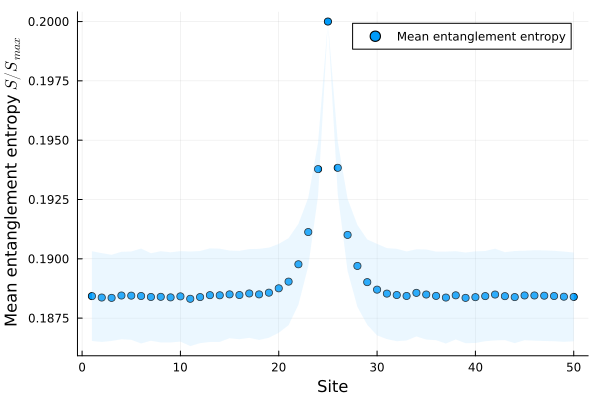

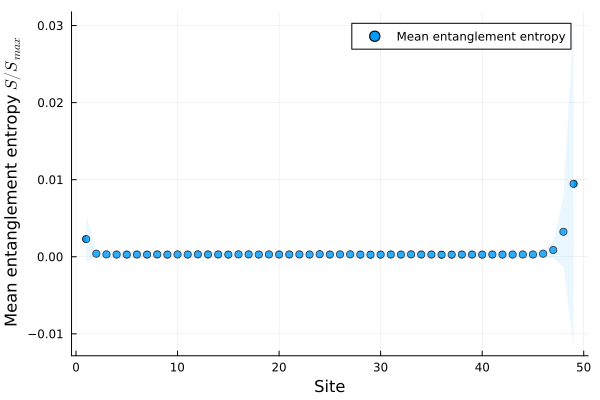

In [258]:
using ProgressMeter
using Statistics
using Colors

list_of_entanglements = []
nr_generated = 1000
@showprogress for i in 1:nr_generated
    entangledMPS, S_max = generate_entangled_mps(50, 10, 2)

    # Once the MPS is generated, lets evaluate its entanglement properties along the chain
    entanglement_along_chain = []
    site_nr = collect(1:length(entangledMPS))
    for i in site_nr
        S_exact =  sum(real, entropy(entangledMPS, i))
        push!(entanglement_along_chain, S_exact)
    end
    normalized_list_of_entanglements = entanglement_along_chain/S_max
    push!(list_of_entanglements, normalized_list_of_entanglements)

end


# code to visualise the data and do the data procressing
# Convert list_of_entanglements to a matrix for easy manipulation
entanglements_matrix = hcat(list_of_entanglements...)

# Calculate mean entanglement for each site
mean_entanglements = mean(entanglements_matrix, dims=2)[:, 1]

# Calculate standard deviation of the mean entanglement for each site
std_entanglements = std(entanglements_matrix, dims=2)[:, 1]

# Plot mean entanglement and standard deviation
site_nr = collect(1:length(mean_entanglements))
p = scatter(site_nr, mean_entanglements, xlabel="Site", ylabel=L" Mean entanglement entropy $S/S_{max}$", label="Mean entanglement entropy", legend=true)

plot!(site_nr, mean_entanglements, ribbon=std_entanglements, fillalpha = 0.25, fillcolor=colorant"lightskyblue1", label="", alpha=0, legend=true)

display(p)


list_of_entanglements = []
nr_generated = 1000
@showprogress for i in 1:nr_generated
    D = 10
    ph = 2
    randomMPS = FiniteMPS(rand, Float64, 50, ℝ^ph, ℝ^D)
    S_max = log10(D)

    #Once the MPS is generated, lets evaluate its entanglement properties along the chain
    entanglement_along_chain = []
    site_nr = collect(1:length(randomMPS))
    for i in site_nr
        S_exact =  sum(real, entropy(randomMPS, i))
        push!(entanglement_along_chain, S_exact)
    end

    for (i,e) in enumerate(entanglement_along_chain)
        if e < 1e-16
            entanglement_along_chain[i] = 1e-4# put a floored representation of 0, such that we can use the logscale
        end
    end

    normalized_list_of_entanglements = entanglement_along_chain[1:end-1]/S_max
    push!(list_of_entanglements, normalized_list_of_entanglements)

end


# code to visualise the data and do the data procressing
# Convert list_of_entanglements to a matrix for easy manipulation
entanglements_matrix = hcat(list_of_entanglements...)

# Calculate mean entanglement for each site
mean_entanglements = mean(entanglements_matrix, dims=2)[:, 1]

# Calculate standard deviation of the mean entanglement for each site
std_entanglements = std(entanglements_matrix, dims=2)[:, 1]

# Plot mean entanglement and standard deviation
site_nr = collect(1:length(mean_entanglements))
p = scatter(site_nr, mean_entanglements, xlabel="Site", ylabel=L" Mean entanglement entropy $S/S_{max}$", label="Mean entanglement entropy", legend=true)

plot!(site_nr, mean_entanglements, ribbon=std_entanglements, fillalpha = 0.25, fillcolor=colorant"lightskyblue1", label="", alpha=0, legend=true)
display(p)

